## Homework 2 Part 2 Task 1: PCA
We will use the Fashion-MNIST dataset to build a PCA model. <br>
https://github.com/zalandoresearch/fashion-mnist <br>
Then, we will use the PCA model to <br>
(1) visualize the data in 2D <br>
(2) generate new images as a generative model <br>
This is a guided-task: <br>
You will see the output of a code cell and then figure out the code in that cell. <br>
In each code cell, there are instructions to help you. <br>
This is a very efficient and effective way to learn how to program with sk-learn

#### First, we load the dataset

In [1]:
# load the data, and it may take a while
from sklearn.datasets import fetch_openml
fasion_mnist=fetch_openml(name="Fashion-MNIST")

In [2]:
data=fasion_mnist.data.values
images=data.reshape(-1,28,28)
target=fasion_mnist.target.astype('int64')

In [3]:
#a row in data is an image (28x28 reshaped into a vector of 784 elements)
data.shape

(70000, 784)

In [4]:
# images[0] is the first image (28x28)
images.shape

(70000, 28, 28)

In [5]:
#an element in target is the class label of the corresponding image in data
target.shape

(70000,)

In [6]:
[target.min(), target.max()]

[0, 9]

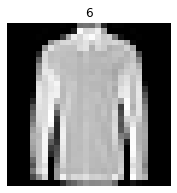

<Figure size 432x288 with 0 Axes>

In [7]:
# show some of the images
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, target.shape[0], 1000):
    x=data[n,:]
    x=x.reshape(28,28) # reshape a vector to an image
    ax.imshow(x, cmap='gray')    
    ax.axis('off')
    ax.set_title(target[n])
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.1)  

#### we need the function plot_components for visualization

In [8]:
from matplotlib import offsetbox
import numpy as np
def plot_components(data, model, images, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    proj = proj/np.sqrt(ipca.explained_variance_)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

### Your work begins here

In [9]:
#use IncrementalPCA (instead of original PCA) in sk-learn
#it runs faster to get the eigenvectors and eigenvalues
#it is more memory efficient
#the function 'fit' computes eigenvectors and eigenvalues
#use 'fit_transform' to do fit and forward transform together
from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(batch_size=None, n_components=2, whiten=False)
proj = ipca.fit_transform(data)
proj.shape

(70000, 2)

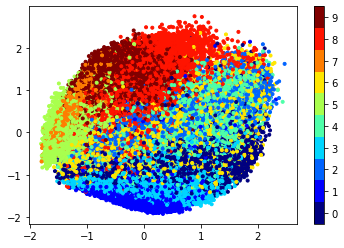

In [10]:
#show the data points in 2D
#you can find example code in my lecture notes (notebook files)
#you need to create a figure and axis:  fig, ax = plt.suplots()
proj = proj/np.sqrt(ipca.explained_variance_)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

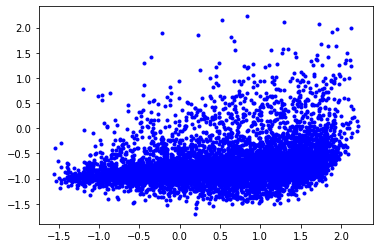

In [11]:
#show only the data points/images with class label=0 (i.e. target is 0) in 2D
plt.scatter(proj[target == 0][:, 0], proj[target == 0][:, 1], c='b', cmap=plt.cm.get_cmap('jet', 10), marker='.')


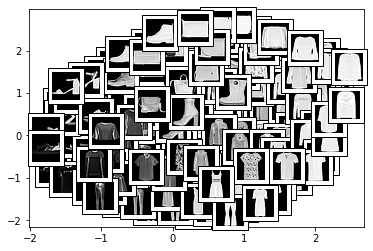

In [12]:
# use plot_components to show the data points
# the parameter 'model' of plot_components refers to the pca model
fig, ax = plt.subplots()
plot_components(data = data,
                model = ipca,
                images=images[:, ::1, ::1])

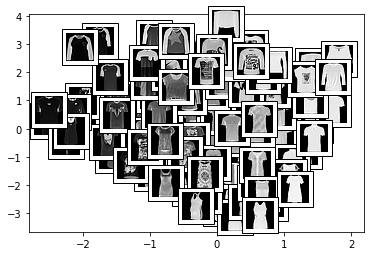

In [13]:
# use plot_components to show the data points with class label=0
# you may need something like this: data[target==0], images[target==0]
fig, ax = plt.subplots()
plot_components(data = data[target == 0],
                model = ipca,
                images=images[target == 0][:, ::1, ::1])

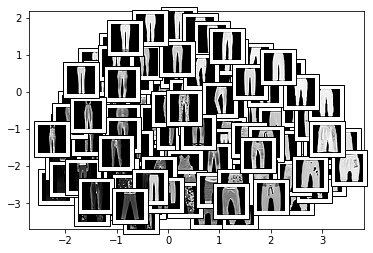

In [14]:
# use plot_components to show the data points with class label=1
# you may need something like this: data[target==1], images[target==1]
fig, ax = plt.subplots()
plot_components(data = data[target == 1],
                model = ipca,
                images=images[target == 1][:, ::1, ::1])

From the above examples, we can see that PCA can extract meaningful features from the images 

### 2. Use PCA to generate new images 

First, we need to figure out how many components we need

In [15]:
#use IncrementalPCA (instead of original PCA) in sk-learn
#set n_components to a large number, e.g, 100
ipca2 = IncrementalPCA(batch_size=None, copy=True, n_components=100, whiten=False)
proj2 = ipca2.fit_transform(data)
proj2.shape

(70000, 100)

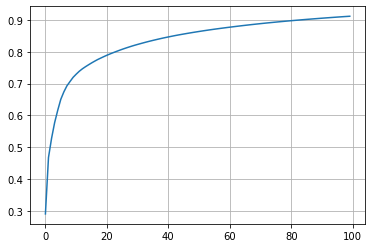

In [16]:
#plot the curve of 'percentage of variance explained' (0~1) vs n_components (0~100)
#apply np.cumsum on explained_variance_ratio_
# use plt.grid() to show grid
plt.plot(np.cumsum(ipca2.explained_variance_ratio_))
plt.grid()

In [17]:
# find the smallest value of n_component such that 
# (1) average reconstruction error is <= 20%
# (2) percentage of variance explained is >= 80%
# (3) cumulative explained variance ratio >= 80%
# (1), (2) and (3) are essentially the same
# you do not need to re-fit the model using this new value of n_component
#from sklearn.metrics import mean_squared_error
explained_variance = ipca2.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

#data_x = ipca2.inverse_transform(proj2)

n_component = 0
while(explained_variance[n_component] > np.percentile(explained_variance, 80) or
     cumulative_variance[n_component] < 0.8):
    n_component += 1

print(n_component)


23


In [18]:
# get the mean, eigenvalues, and eigenvectors from the pca model
# assume that:
# the name of mean is mu
# the name of eigenvalues is v (a 1D array)
# the name of eigenvectors is w (a 2D array)
mu = ipca2.mean_
v = ipca2.explained_variance_
w = ipca2.components_

In [19]:
v.shape

(100,)

In [20]:
w.shape

(100, 784)

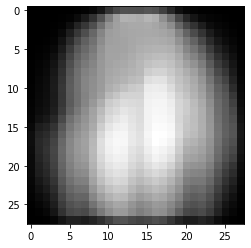

In [21]:
# plot the mean image from pca
# you need to reshape it to 28x28
plt.imshow(mu.reshape(28,28), cmap='gray')

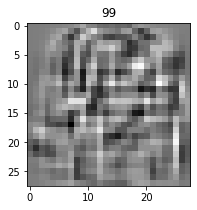

<Figure size 432x288 with 0 Axes>

In [22]:
# use a for loop to show the images of eigenvectors
# image is w[n].reshape(28,28)
# sample code:

fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, 100):
    ax.imshow(w[n].reshape(28,28), cmap='gray')    
    ax.set_title(n)
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.2) 


In [23]:
# L2 norm of an eigenvector w[0]
np.sum(w[0]**2)

1.000000000000003

In [24]:
# generate a random number
3*np.random.randn()

-3.6060348600188243

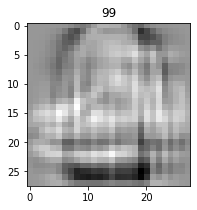

<Figure size 432x288 with 0 Axes>

In [26]:
# generate and show the new images
# use a for loop to geneate 100 new images
#     inside the for loop
#     x_new = mu + y[0]*sqrt(v[0])*w[0]+...+y[K]*sqrt(v[K])*w[K]
#     use a for loop to get X_new using the above equation
#     K is the number of components
#     y[k] is a random number generated using 3*np.random.randn()
fig, ax = plt.subplots(figsize=(3, 3))
x_new = mu
for n in range(0, 100):
    #x_new = mu + y[0]*sqrt(v[0])*w[0]+...+y[K]*sqrt(v[K])*w[K]
    x_new += 3*np.random.randn()*np.sqrt(v[n])*w[n]
    x_new_r = x_new.reshape(28,28)  
    ax.imshow(x_new_r, cmap='gray')   
    ax.set_title(n)
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.1) 

PCA is not good at generating images. <br>
There is a better method based on neural networks.

### t-SNE for visualization

In [27]:
#select a subset of data points for TSNE
#because TSNE is very time-consuming
data_s=data[0::100]
target_s=target[0::100]
images_s=images[0::100]

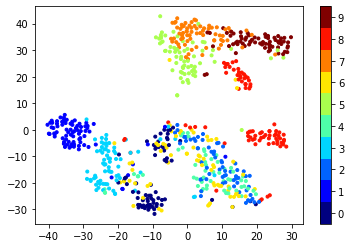

In [30]:
# run t-SNE on data_s and visualize the data in 2D using scatter plot
from sklearn.manifold import TSNE
model = TSNE(n_components=2)
proj_s = model.fit_transform(data_s)
plt.scatter(proj_s[:, 0], proj_s[:, 1], c=target_s, cmap=plt.cm.get_cmap('jet', 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);